In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import os
import joblib
import warnings
warnings.filterwarnings('ignore')

In [13]:
# Set up paths (same as original code)
BASE_PATH = '/workspace/COMP-3608---PROJECT'
DATA_PATH = os.path.join(BASE_PATH, 'data')
MODELS_PATH = os.path.join(BASE_PATH, 'models')
RESULTS_PATH = os.path.join(BASE_PATH, 'results')

In [14]:
def plot_confusion_matrix(cm, class_names, title):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title(title)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.savefig(os.path.join(RESULTS_PATH, f"{title.replace(' ', '_')}.png"))
    plt.show()


In [15]:
def plot_roc_curve(fpr, tpr, roc_auc, title):
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")
    plt.savefig(os.path.join(RESULTS_PATH, f"{title.replace(' ', '_')}.png"))
    plt.show()

In [16]:
def print_metrics(y_true, y_pred, model_name):
    """Print and return metrics for a model's predictions"""
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    
    print(f"\nModel: {model_name}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, zero_division=0))
    
    # Create confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'confusion_matrix': cm
    }

In [17]:
def ensemble_voting_classifier(model_dict, X_test, y_test, dataset_name, voting='hard'):

    print(f"\n{'-'*50}")
    print(f"Creating Ensemble for {dataset_name} dataset")
    
    model_predictions = {}
    model_probabilities = {}
    
    # Get predictions from each model
    for name, model in model_dict.items():
        model_predictions[name] = model.predict(X_test)
        model_probabilities[name] = model.predict_proba(X_test)[:, 1]
    
    if voting == 'hard':
        # Majority voting (hard voting)
        ensemble_pred = np.zeros(len(y_test))
        for name in model_predictions:
            ensemble_pred += model_predictions[name]
        
        # If more than half of the models predicted 1, set to 1
        ensemble_pred = (ensemble_pred >= len(model_dict)/2).astype(int)
    
    elif voting == 'soft':
        # Averaging probabilities (soft voting)
        ensemble_prob = np.zeros(len(y_test))
        for name in model_probabilities:
            ensemble_prob += model_probabilities[name]
        
        ensemble_prob /= len(model_probabilities)  # average probabilities
        ensemble_pred = (ensemble_prob >= 0.5).astype(int)
    
    # Calculate ensemble metrics
    metrics = print_metrics(y_test, ensemble_pred, f"Ensemble ({voting} voting)")
    
    # Plot confusion matrix
    plot_confusion_matrix(
        metrics['confusion_matrix'], 
        ['Negative', 'Positive'], 
        f'Confusion Matrix - Ensemble {voting.capitalize()} Voting ({dataset_name})'
    )
    
    # Calculate and plot ROC curve (for soft voting)
    if voting == 'soft':
        fpr, tpr, _ = roc_curve(y_test, ensemble_prob)
        roc_auc = auc(fpr, tpr)
        plot_roc_curve(
            fpr, tpr, roc_auc, 
            f'ROC Curve - Ensemble {voting.capitalize()} Voting ({dataset_name})'
        )
    
    return {
        'metrics': metrics,
        'predictions': ensemble_pred,
        'probabilities': ensemble_prob if voting == 'soft' else None
    }

In [18]:

def create_ensemble_for_dataset(dataset_name, X_test, y_test):
    """Load models for a dataset and create ensemble"""
    model_types = ['logistic_regression', 'random_forest', 'xgboost']
    models = {}
    
    # Load trained models
    for model_type in model_types:
        model_path = os.path.join(MODELS_PATH, f"{dataset_name}_{model_type}.pkl")
        try:
            models[model_type.replace('_', ' ').title()] = joblib.load(model_path)
            print(f"Loaded model from {model_path}")
        except FileNotFoundError:
            print(f"Model file {model_path} not found. Skipping.")
    
    # Create ensemble models (both hard and soft voting)
    ensemble_results = {
        'hard': ensemble_voting_classifier(models, X_test, y_test, dataset_name, voting='hard'),
        'soft': ensemble_voting_classifier(models, X_test, y_test, dataset_name, voting='soft')
    }
    
    # Only print ensemble summary (no base model details)
    print(f"\nEnsemble Summary for {dataset_name} dataset:")
    print(f"Hard Voting - F1 Score: {ensemble_results['hard']['metrics']['f1']:.4f}")
    print(f"Soft Voting - F1 Score: {ensemble_results['soft']['metrics']['f1']:.4f}")
    
    return ensemble_results

In [19]:

def prepare_data_with_smote(df, target_column, categorical_cols=None, numerical_cols=None):
    """Prepare data for modeling using SMOTE for imbalanced data"""
    
    if categorical_cols is None:
        categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
    
    if numerical_cols is None:
        numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
        # Remove ID columns and target from numerical features if present
        numerical_cols = [col for col in numerical_cols if col != target_column and 'id' not in col.lower()]
    
    # Ensure target column is removed from features
    categorical_cols = [col for col in categorical_cols if col != target_column]
    numerical_cols = [col for col in numerical_cols if col != target_column]
    
    # Preprocessing pipeline
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numerical_cols),
            ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_cols)
        ])
    
    # Split data
    X = df.drop(target_column, axis=1)
    y = df[target_column]
    
    # Split into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    
    # Preprocess the data
    X_train_processed = preprocessor.fit_transform(X_train)
    X_test_processed = preprocessor.transform(X_test)
    
    # Apply SMOTE to the training data
    smote = SMOTE(random_state=42)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train_processed, y_train)
    
    print(f"Original class distribution: {np.bincount(y_train)}")
    print(f"After SMOTE: {np.bincount(y_train_resampled)}")
    
    return X_train_resampled, X_test_processed, y_train_resampled, y_test, preprocessor


Starting Ensemble Model Evaluation with SMOTE...

Loading Diabetes Dataset...
Original class distribution: [73200  6800]
After SMOTE: [73200 73200]
Loaded model from /workspace/COMP-3608---PROJECT/models/diabetes_logistic_regression.pkl
Loaded model from /workspace/COMP-3608---PROJECT/models/diabetes_random_forest.pkl
Loaded model from /workspace/COMP-3608---PROJECT/models/diabetes_xgboost.pkl

--------------------------------------------------
Creating Ensemble for diabetes dataset

Model: Ensemble (hard voting)
Accuracy: 0.9611
Precision: 0.7840
Recall: 0.7494
F1 Score: 0.7663

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98     18300
           1       0.78      0.75      0.77      1700

    accuracy                           0.96     20000
   macro avg       0.88      0.87      0.87     20000
weighted avg       0.96      0.96      0.96     20000



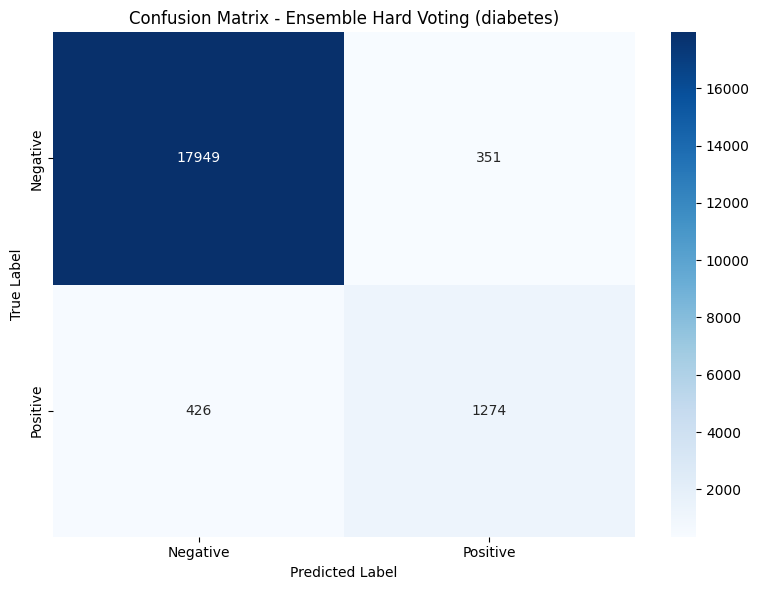


--------------------------------------------------
Creating Ensemble for diabetes dataset

Model: Ensemble (soft voting)
Accuracy: 0.9586
Precision: 0.7539
Recall: 0.7606
F1 Score: 0.7572

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98     18300
           1       0.75      0.76      0.76      1700

    accuracy                           0.96     20000
   macro avg       0.87      0.87      0.87     20000
weighted avg       0.96      0.96      0.96     20000



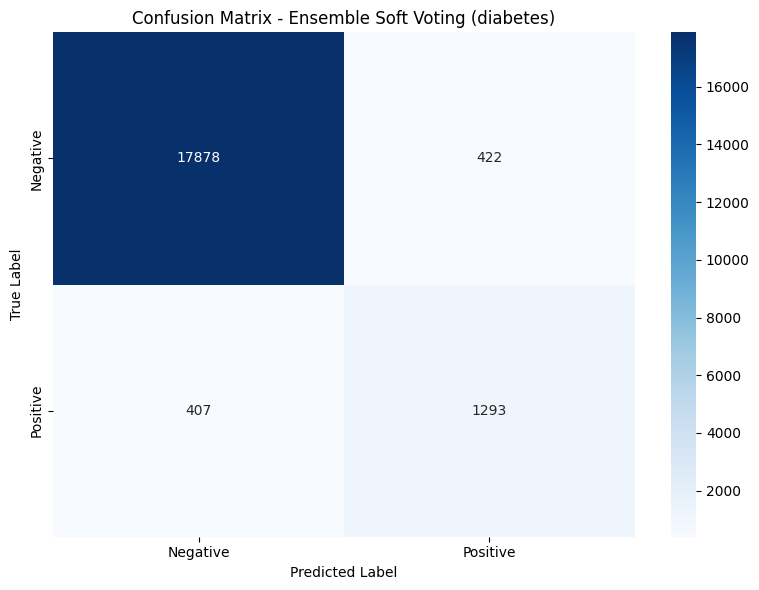

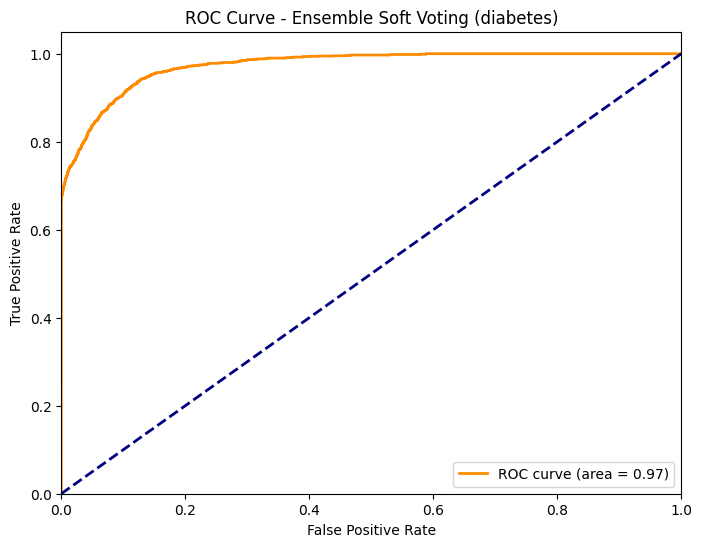


Ensemble Summary for diabetes dataset:
Hard Voting - F1 Score: 0.7663
Soft Voting - F1 Score: 0.7572

Loading Stroke Dataset...
Original class distribution: [3889  199]
After SMOTE: [3889 3889]
Loaded model from /workspace/COMP-3608---PROJECT/models/stroke_logistic_regression.pkl
Loaded model from /workspace/COMP-3608---PROJECT/models/stroke_random_forest.pkl
Loaded model from /workspace/COMP-3608---PROJECT/models/stroke_xgboost.pkl

--------------------------------------------------
Creating Ensemble for stroke dataset

Model: Ensemble (hard voting)
Accuracy: 0.8806
Precision: 0.1949
Recall: 0.4600
F1 Score: 0.2738

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.90      0.93       972
           1       0.19      0.46      0.27        50

    accuracy                           0.88      1022
   macro avg       0.58      0.68      0.60      1022
weighted avg       0.93      0.88      0.90      1022



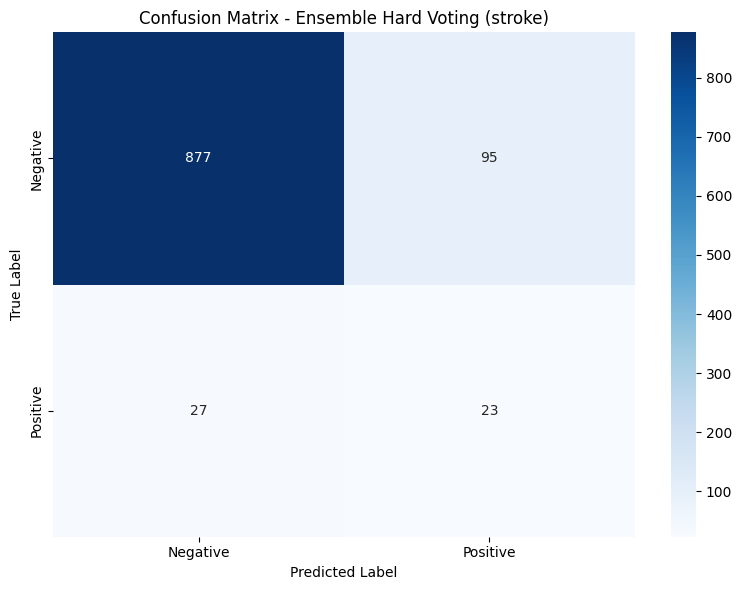


--------------------------------------------------
Creating Ensemble for stroke dataset

Model: Ensemble (soft voting)
Accuracy: 0.8777
Precision: 0.2000
Recall: 0.5000
F1 Score: 0.2857

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.90      0.93       972
           1       0.20      0.50      0.29        50

    accuracy                           0.88      1022
   macro avg       0.59      0.70      0.61      1022
weighted avg       0.93      0.88      0.90      1022



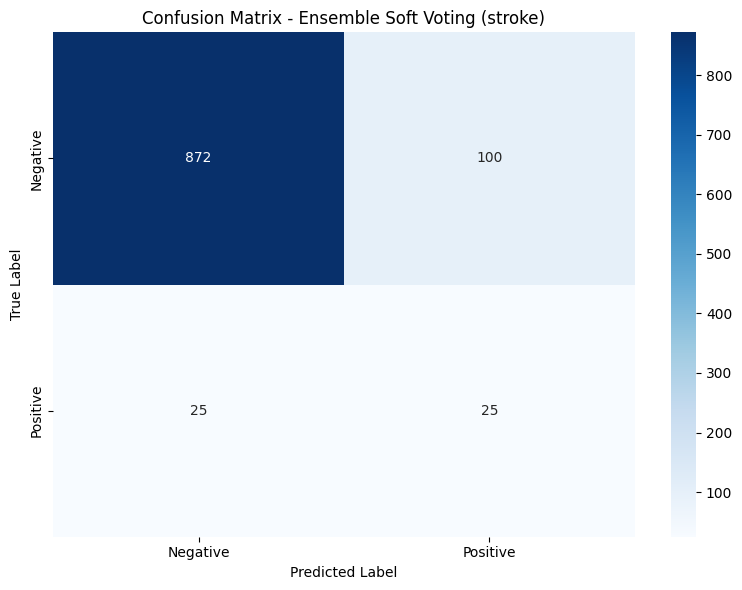

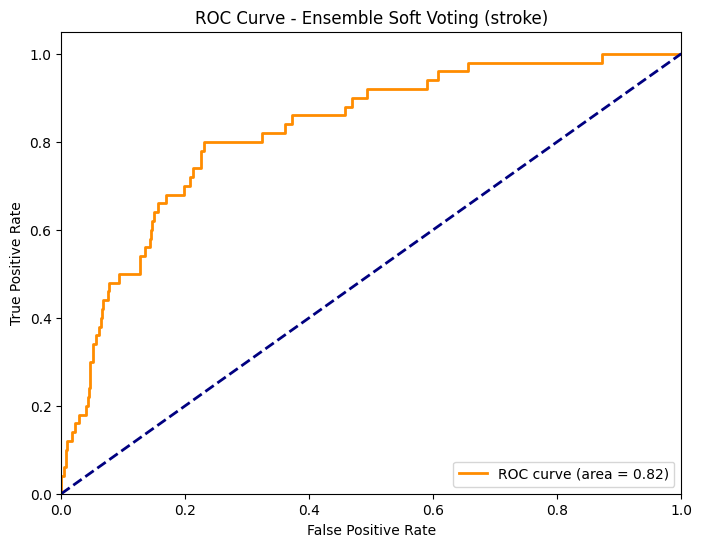


Ensemble Summary for stroke dataset:
Hard Voting - F1 Score: 0.2738
Soft Voting - F1 Score: 0.2857

Loading Heart Disease Dataset...
Original class distribution: [329 407]
After SMOTE: [407 407]
Loaded model from /workspace/COMP-3608---PROJECT/models/heart_logistic_regression.pkl
Loaded model from /workspace/COMP-3608---PROJECT/models/heart_random_forest.pkl
Loaded model from /workspace/COMP-3608---PROJECT/models/heart_xgboost.pkl

--------------------------------------------------
Creating Ensemble for heart dataset

Model: Ensemble (hard voting)
Accuracy: 0.8152
Precision: 0.8333
Recall: 0.8333
F1 Score: 0.8333

Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.79      0.79        82
           1       0.83      0.83      0.83       102

    accuracy                           0.82       184
   macro avg       0.81      0.81      0.81       184
weighted avg       0.82      0.82      0.82       184



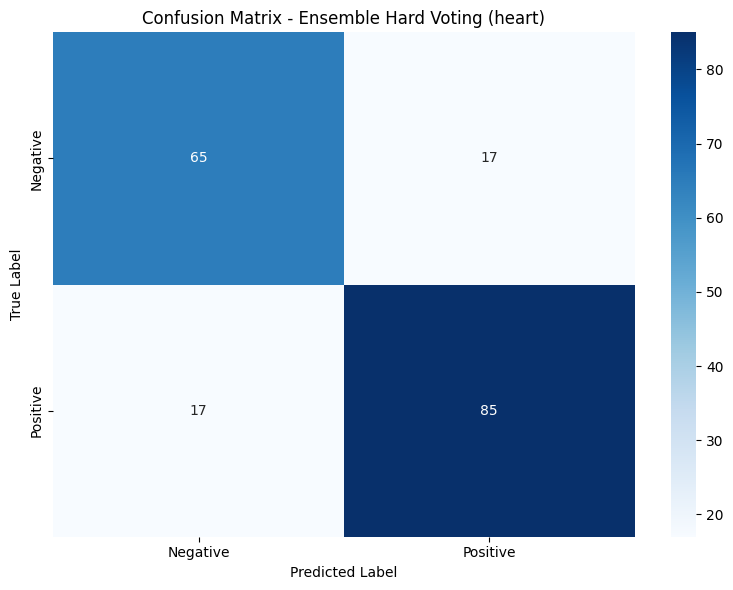


--------------------------------------------------
Creating Ensemble for heart dataset

Model: Ensemble (soft voting)
Accuracy: 0.8207
Precision: 0.8350
Recall: 0.8431
F1 Score: 0.8390

Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.79      0.80        82
           1       0.83      0.84      0.84       102

    accuracy                           0.82       184
   macro avg       0.82      0.82      0.82       184
weighted avg       0.82      0.82      0.82       184



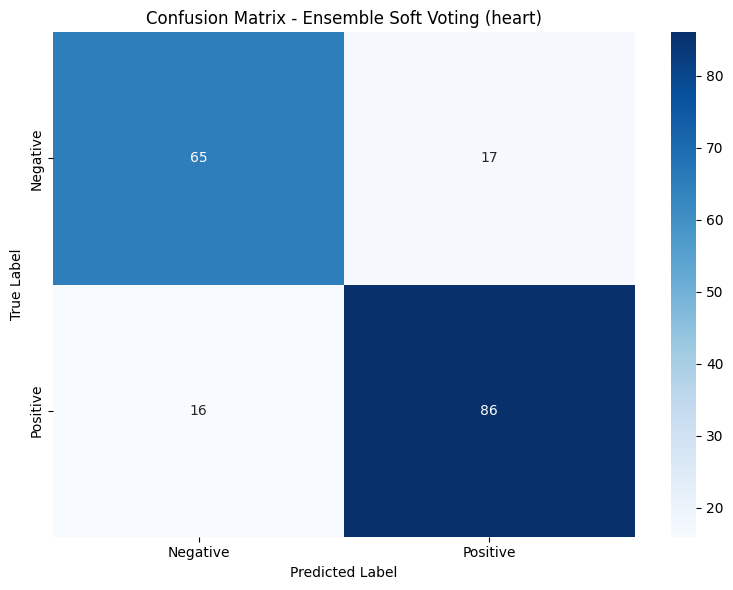

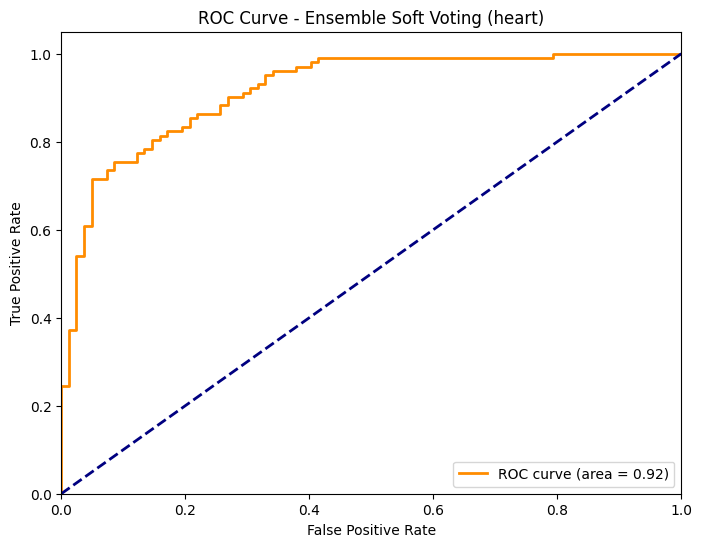


Ensemble Summary for heart dataset:
Hard Voting - F1 Score: 0.8333
Soft Voting - F1 Score: 0.8390

SUMMARY OF ENSEMBLE RESULTS

Diabetes:
Hard Voting - F1: 0.7663, Precision: 0.7840, Recall: 0.7494
Soft Voting - F1: 0.7572, Precision: 0.7539, Recall: 0.7606

Stroke:
Hard Voting - F1: 0.2738, Precision: 0.1949, Recall: 0.4600
Soft Voting - F1: 0.2857, Precision: 0.2000, Recall: 0.5000

Heart Disease:
Hard Voting - F1: 0.8333, Precision: 0.8333, Recall: 0.8333
Soft Voting - F1: 0.8390, Precision: 0.8350, Recall: 0.8431


In [20]:
# Main execution
if __name__ == "__main__":
    print("Starting Ensemble Model Evaluation with SMOTE...")
    
    # Process Diabetes Dataset
    print("\nLoading Diabetes Dataset...")
    diabetes_df = pd.read_csv(os.path.join(DATA_PATH, 'feature_engineering/diabetes_feature_engineering'))
    diabetes_cat_cols = ['gender', 'smoking_history', 'age_group', 'bmi_category', 'glucose_tolerance']
    diabetes_num_cols = [col for col in diabetes_df.columns if col not in diabetes_cat_cols + ['diabetes']]
    
    # Prepare diabetes data with SMOTE
    X_train_diabetes, X_test_diabetes, y_train_diabetes, y_test_diabetes, _ = prepare_data_with_smote(
        diabetes_df, 'diabetes', diabetes_cat_cols, diabetes_num_cols
    )
    
    # Create ensemble for diabetes
    diabetes_ensemble_results = create_ensemble_for_dataset('diabetes', X_test_diabetes, y_test_diabetes)
    
    # Process Stroke Dataset
    print("\nLoading Stroke Dataset...")
    stroke_df = pd.read_csv(os.path.join(DATA_PATH, 'feature_engineering/Stroke_feature_engineering'))
    stroke_cat_cols = ['glucose_risk']
    stroke_num_cols = [col for col in stroke_df.columns 
                      if col not in stroke_cat_cols + ['stroke', 'age_group'] 
                      and not col.startswith('gender_') 
                      and not col.startswith('ever_married_')
                      and not col.startswith('work_type_')
                      and not col.startswith('Residence_type_')
                      and not col.startswith('smoking_status_')]
    
    # Prepare stroke data with SMOTE
    X_train_stroke, X_test_stroke, y_train_stroke, y_test_stroke, _ = prepare_data_with_smote(
        stroke_df, 'stroke', stroke_cat_cols, stroke_num_cols
    )
    
    # Create ensemble for stroke
    stroke_ensemble_results = create_ensemble_for_dataset('stroke', X_test_stroke, y_test_stroke)
    
    # Process Heart Disease Dataset
    print("\nLoading Heart Disease Dataset...")
    heart_df = pd.read_csv(os.path.join(DATA_PATH, 'feature_engineering/heart_feature_engineering'))
    
    # Convert 'num' to a binary classification problem if needed
    if heart_df['num'].nunique() > 2:
        heart_df['heart_disease'] = (heart_df['num'] > 0).astype(int)
        target_column = 'heart_disease'
    else:
        target_column = 'num'
    
    heart_cat_cols = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'age_group', 'blood_pressure', 'chol_risk', 'dataset']
    heart_num_cols = [col for col in heart_df.columns if col not in heart_cat_cols + [target_column, 'num', 'id']]
    
    # Prepare heart disease data with SMOTE
    X_train_heart, X_test_heart, y_train_heart, y_test_heart, _ = prepare_data_with_smote(
        heart_df, target_column, heart_cat_cols, heart_num_cols
    )
    
    # Create ensemble for heart disease
    heart_ensemble_results = create_ensemble_for_dataset('heart', X_test_heart, y_test_heart)
    
    # Summary of all ensemble results
    print("\n" + "="*50)
    print("SUMMARY OF ENSEMBLE RESULTS")
    print("="*50)
    
    for dataset_name, results in [
        ('Diabetes', diabetes_ensemble_results),
        ('Stroke', stroke_ensemble_results),
        ('Heart Disease', heart_ensemble_results)
    ]:
        print(f"\n{dataset_name}:")
        print(f"Hard Voting - F1: {results['hard']['metrics']['f1']:.4f}, "
              f"Precision: {results['hard']['metrics']['precision']:.4f}, "
              f"Recall: {results['hard']['metrics']['recall']:.4f}")
        print(f"Soft Voting - F1: {results['soft']['metrics']['f1']:.4f}, "
              f"Precision: {results['soft']['metrics']['precision']:.4f}, "
              f"Recall: {results['soft']['metrics']['recall']:.4f}")
    

